# 0. Library

In [4]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import time
import pickle
import os # Added for path handling
import torch

# --- Sklearn ---
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict # Added cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, roc_curve, precision_recall_curve, auc,
                             accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, brier_score_loss, log_loss, classification_report)
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.ensemble import StackingClassifier
from sklearn.base import clone
from sklearn.feature_selection import VarianceThreshold # Added for feature selection

# --- Imbalanced Learn ---
from imblearn.pipeline import Pipeline as ImblearnPipeline
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE

# --- Model Specific Libraries ---
import xgboost as xgb
import lightgbm as lgb

# --- WOE/Scorecard Library ---
# import scorecardpy as sc # For LR+WOE variant (Keep commented if not using)

# --- Bayesian Optimization ---
import optuna # Added Optuna

# --- Display Options ---
# Set display options (optional but helpful)
pd.set_option('display.max_columns', None) # Show all columns
pd.set_option('display.max_rows', 100)    # Show more rows
pd.set_option('display.float_format', lambda x: '%.5f' % x) # Format floats
warnings.filterwarnings('ignore', category=FutureWarning) # Ignore specific warnings if needed
warnings.filterwarnings('ignore', category=UserWarning)

c:\Users\ORLab\main_source\CreditRiskProject\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# --- GPU Configuration for PyTorch ---
def setup_device():
    """Setup and configure PyTorch device (GPU if available)"""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        # Print GPU information
        gpu_props = torch.cuda.get_device_properties(0)
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {gpu_props.total_memory / 1e9:.2f} GB")
        print(f"CUDA Version: {torch.version.cuda}")
        
        # Set memory usage behavior
        torch.backends.cudnn.benchmark = True  # May speed up training if input sizes don't vary
        # torch.backends.cudnn.deterministic = True  # Uncomment for full reproducibility (but slower)
        
        # Optional: Set PyTorch to allocate memory as needed rather than all at once
        if hasattr(torch.cuda, 'set_per_process_memory_fraction'):
            torch.cuda.set_per_process_memory_fraction(0.9)  # Use up to 90% of GPU memory
            
        # Print memory usage
        print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
        print(f"GPU Memory Reserved: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")
    else:
        device = torch.device("cpu")
        print("No GPU available, using CPU")
        
        # Check if MPS is available (Apple Silicon GPU)
        if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
            device = torch.device("mps")
            print("Using Apple Silicon GPU (MPS)")
    
    # Set default dtype for better numerical precision if needed
    # torch.set_default_dtype(torch.float32)  # Default is already float32
    # For reproducibility
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(SEED)
    
    return device

# Set up device
device = setup_device()

# --- Configuration ---
DATA_PATH = '../data/processed/'
MODEL_OUTPUT_PATH = './model_outputs/'  # Directory to save Optuna studies, results
os.makedirs(MODEL_OUTPUT_PATH, exist_ok=True)  # Create output dir if needed
SEED = 42
N_SPLITS = 5  # Number of folds for Cross-Validation
SMOTE_STRATEGY = 0.25  # Ratio of minority samples to majority after resampling
# Choose SMOTE variant: SMOTE, ADASYN, BorderlineSMOTE
SMOTE_VARIANT = BorderlineSMOTE(sampling_strategy=SMOTE_STRATEGY, random_state=SEED)
OPTUNA_N_TRIALS = 50  # Number of trials for Optuna optimization (adjust as needed)

Using GPU: NVIDIA GeForce RTX 3060
GPU Memory: 12.88 GB
CUDA Version: 12.6
GPU Memory Allocated: 0.00 GB
GPU Memory Reserved: 0.00 GB


# 1. Utility Function + Configuration

In [24]:
# --- Helper Functions ---
def calculate_ks(y_true, y_prob):
    """Calculates the Kolmogorov-Smirnov (KS) statistic."""
    df = pd.DataFrame({'y_true': y_true, 'y_prob': y_prob})
    df = df.sort_values(by='y_prob', ascending=False)
    df['cumulative_true'] = df['y_true'].cumsum() / df['y_true'].sum()
    df['cumulative_false'] = (1 - df['y_true']).cumsum() / (1 - df['y_true']).sum()
    ks = max(abs(df['cumulative_true'] - df['cumulative_false']))
    return ks

def find_optimal_threshold_j_statistic(y_true, y_prob_oof):
    """Finds the optimal threshold maximizing Youden's J statistic (Sensitivity + Specificity - 1)."""
    fpr, tpr, thresholds = roc_curve(y_true, y_prob_oof)
    j_statistic = tpr - fpr
    optimal_idx = np.argmax(j_statistic)
    optimal_threshold = thresholds[optimal_idx]
    print(f"Optimal threshold based on Youden's J-Statistic (OOF): {optimal_threshold:.4f}")
    return optimal_threshold

def evaluate_model(y_true, y_pred_proba, y_pred_binary, model_name="Model"):
    """Calculates and prints standard classification metrics."""
    auc_roc = roc_auc_score(y_true, y_pred_proba)
    gini = 2 * auc_roc - 1
    ks = calculate_ks(y_true, y_pred_proba)
    accuracy = accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    brier = brier_score_loss(y_true, y_pred_proba)
    logloss = log_loss(y_true, y_pred_proba)
    cm = confusion_matrix(y_true, y_pred_binary)

    print(f"\n--- Evaluation Metrics for {model_name} ---")
    print(f"AUC ROC:        {auc_roc:.4f}")
    print(f"Gini Coefficient: {gini:.4f}")
    print(f"KS Statistic:   {ks:.4f}")
    print(f"Accuracy:       {accuracy:.4f}")
    print(f"Precision:      {precision:.4f}")
    print(f"Recall (TPR):   {recall:.4f}")
    print(f"F1-Score:       {f1:.4f}")
    print(f"Brier Score:    {brier:.4f}")
    print(f"Log Loss:       {logloss:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    # print("\nClassification Report:")
    # print(classification_report(y_true, y_pred_binary))

    results = {
        'Model': model_name,
        'AUC': auc_roc,
        'Gini': gini,
        'KS': ks,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Brier': brier,
        'LogLoss': logloss
    }
    return results

def plot_roc_curve(y_true, y_prob, model_name):
    """Plots the ROC curve."""
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_roc = roc_auc_score(y_true, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_roc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--') # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

def get_feature_importance(model, feature_names, top_n=50):
    """Extracts and displays feature importances."""
    print(f"\n--- Top {top_n} Feature Importances ---")
    try:
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            # For linear models, use absolute coefficient values
            importances = np.abs(model.coef_[0]) # Assuming binary classification coef_[0]
        else:
            print("Model does not have standard feature_importances_ or coef_ attribute.")
            return None

        feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

        # Check if importance sum is close to 1 (typical for tree models)
        print(f"Sum of importances: {feature_importance_df['importance'].sum():.4f}")

        display(feature_importance_df.head(top_n))
        return feature_importance_df

    except Exception as e:
        print(f"Could not get feature importances: {e}")
        return None


In [25]:
# --- Configuration ---
DATA_PATH = '../data/processed/'
MODEL_OUTPUT_PATH = './model_outputs/' # Directory to save Optuna studies, results
os.makedirs(MODEL_OUTPUT_PATH, exist_ok=True) # Create output dir if needed
SEED = 42
N_SPLITS = 5 # Number of folds for Cross-Validation
SMOTE_STRATEGY = 0.25 # Ratio of minority samples to majority after resampling
# Choose SMOTE variant: SMOTE, ADASYN, BorderlineSMOTE
SMOTE_VARIANT = BorderlineSMOTE(sampling_strategy=SMOTE_STRATEGY, random_state=SEED) # Use n_jobs for BorderlineSMOTE if available
OPTUNA_N_TRIALS = 50 # Number of trials for Optuna optimization (adjust as needed)

# --- Check for GPU ---
# Define device_name globally before any model uses it
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device_name}")

Using device: cpu


# 2. Data Loading and Preprocessing

In [26]:
print("Loading preprocessed data...")
try:
    train_df = pd.read_csv(DATA_PATH + 'train_final.csv')
    test_df = pd.read_csv(DATA_PATH + 'test_final.csv')
    print("Data loaded successfully.")
    print(f"Train shape: {train_df.shape}")
    print(f"Test shape: {test_df.shape}")
except FileNotFoundError as e:
    print(f"Error: {e}. Make sure 'train_final.csv' and 'test_final.csv' are in {DATA_PATH}")
    # Exit or raise error if files not found
    raise FileNotFoundError(f"Data files not found in {DATA_PATH}")
except Exception as e:
    print(f"An error occurred while loading data: {e}")
    raise # Exit or raise error if any other issue occurs

Loading preprocessed data...
Data loaded successfully.
Train shape: (246005, 775)
Test shape: (61502, 775)


In [27]:
# --- Prepare Data for Modeling ---
TARGET = 'TARGET'
ID_COL = 'SK_ID_CURR' # Assuming ID column might still be present

# Align columns - crucial if feature engineering created different cols slightly
train_labels = train_df[TARGET]
test_labels = test_df[TARGET]

# Drop Target and potentially ID from features
if ID_COL in train_df.columns:
    train_ids = train_df[ID_COL]
    test_ids = test_df[ID_COL]
    train_df = train_df.drop(columns=[TARGET, ID_COL])
    test_df = test_df.drop(columns=[TARGET, ID_COL])
else:
    train_df = train_df.drop(columns=[TARGET])
    test_df = test_df.drop(columns=[TARGET])

# Ensure columns are in the same order
common_cols = list(train_df.columns.intersection(test_df.columns))
X_train = train_df[common_cols].copy()
X_test = test_df[common_cols].copy()
y_train = train_labels.copy()
y_test = test_labels.copy()

# Capture feature names for later use
feature_names = X_train.columns.tolist()

print(f"Prepared X_train shape: {X_train.shape}")
print(f"Prepared X_test shape: {X_test.shape}")
print(f"Number of features: {len(feature_names)}")

# --- Cross-Validation Setup ---
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

# --- Results Storage ---
baseline_results = []
tuned_results = []
model_objects = {} # To store best tuned models for stacking

Prepared X_train shape: (246005, 773)
Prepared X_test shape: (61502, 773)
Number of features: 773


## 2.1 Featue Selection

- Step:
    + Remove Low Variance Features
    + Remove Correlated Features

In [28]:
# --- Feature Selection: Low Variance Filter ---
print("\nApplying Low Variance Feature Selection...")
var_selector = VarianceThreshold(threshold=0.01) # Threshold=0 removes zero-variance, 0.01 removes low variance

# Fit on training data only
var_selector.fit(X_train)

# Get the boolean mask of selected features
feature_mask = var_selector.get_support()
original_feature_names = X_train.columns.tolist() # Get original names before transformation
selected_feature_names = [name for name, selected in zip(original_feature_names, feature_mask) if selected]

print(f"Original number of features: {X_train.shape[1]}")
print(f"Number of features after variance thresholding: {len(selected_feature_names)}")

# Transform both X_train and X_test
X_train_np_selected = var_selector.transform(X_train)
X_test_np_selected = var_selector.transform(X_test)

# Convert back to DataFrame with selected column names
X_train = pd.DataFrame(X_train_np_selected, columns=selected_feature_names, index=X_train.index)
X_test = pd.DataFrame(X_test_np_selected, columns=selected_feature_names, index=X_test.index)

# Update the global feature_names list
feature_names = selected_feature_names

print(f"Updated X_train shape: {X_train.shape}")
print(f"Updated X_test shape: {X_test.shape}")


Applying Low Variance Feature Selection...
Original number of features: 773
Number of features after variance thresholding: 542
Updated X_train shape: (246005, 542)
Updated X_test shape: (61502, 542)


# 3. Model 1: Logistic Regression + WOE

In [29]:
# # --- Model 1: Logistic Regression + WOE (Special Handling) ---
# print("\n" + "="*60)
# print("Model 1: Logistic Regression + WOE")
# print("="*60)

# # Step 1.1: WOE Binning (Fit ONLY on Training Data)
# # Filter features with IV > 0.02 (common practice)
# # Handle potential infinite values after Response Encoding if needed before WOE
# X_train_woe_input = X_train.replace([np.inf, -np.inf], np.nan) # Replace inf
# X_test_woe_input = X_test.replace([np.inf, -np.inf], np.nan)

# # Impute remaining NaNs before WOE binning (median for numeric)
# # Consider if specific imputation was done before saving CSVs
# num_cols = X_train_woe_input.select_dtypes(include=np.number).columns
# for col in num_cols:
#      median_val = X_train_woe_input[col].median()
#      X_train_woe_input[col] = X_train_woe_input[col].fillna(median_val)
#      X_test_woe_input[col] = X_test_woe_input[col].fillna(median_val) # Use train median for test

# print("Starting WOE binning (fit on train data)...")
# bins = sc.woebin(X_train_woe_input.join(y_train), y=TARGET, positive=TARGET+'|1', method='chimerge', bin_num_limit=10)
# # sc.woebin_plot(bins) # Optional: Visualize bins

# # Filter bins by IV > 0.02
# significant_bins = {k: v for k, v in bins.items() if v['total_iv'].iloc[0] > 0.02}
# woe_features = list(significant_bins.keys())
# print(f"Selected {len(woe_features)} features based on IV > 0.02 for WOE LR.")

# if not woe_features:
#      print("Warning: No features found with IV > 0.02. WOE LR cannot proceed.")
# else:
#     # Step 1.2: Apply WOE Transformation
#     print("Applying WOE transformation...")
#     X_train_woe = sc.woebin_ply(X_train_woe_input[woe_features], significant_bins)
#     X_test_woe = sc.woebin_ply(X_test_woe_input[woe_features], significant_bins)
#     woe_feature_names = X_train_woe.columns.tolist() # Capture WOE feature names

#     # Step 1.3: Baseline LR + WOE (No SMOTE/Scaling)
#     print("\n--- Baseline LR + WOE Training ---")
#     lr_woe_base = LogisticRegression(random_state=SEED, solver='liblinear', class_weight='balanced') # Balanced weights as proxy for SMOTE
#     lr_woe_base.fit(X_train_woe, y_train)

#     y_pred_proba_test_base = lr_woe_base.predict_proba(X_test_woe)[:, 1]
#     # Use 0.5 threshold for baseline report
#     y_pred_bin_test_base = (y_pred_proba_test_base >= 0.5).astype(int)
#     baseline_results.append(evaluate_model(y_test, y_pred_proba_test_base, y_pred_bin_test_base, "LR + WOE (Baseline)"))
#     plot_roc_curve(y_test, y_pred_proba_test_base, "LR + WOE (Baseline)")
#     get_feature_importance(lr_woe_base, woe_feature_names)

#     # Step 1.4: Hyperparameter Tuning (Tuning C)
#     print("\n--- Tuned LR + WOE Training ---")
#     param_grid_lr_woe = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
#     # Note: No pipeline needed here, tuning directly on WOE data
#     grid_search_lr_woe = GridSearchCV(LogisticRegression(random_state=SEED, solver='liblinear', class_weight='balanced'),
#                                       param_grid_lr_woe, cv=cv, scoring='roc_auc', n_jobs=-1, refit=True)
#     grid_search_lr_woe.fit(X_train_woe, y_train)
#     best_lr_woe = grid_search_lr_woe.best_estimator_
#     print(f"Best Params (LR + WOE): {grid_search_lr_woe.best_params_}")

#     # Step 1.5: Optimal Threshold and Evaluation
#     # Get OOF predictions on WOE-transformed training data
#     y_prob_oof_lr_woe = cross_val_predict(best_lr_woe, X_train_woe, y_train, cv=cv, method='predict_proba')[:, 1]
#     optimal_threshold_lr_woe = find_optimal_threshold_j_statistic(y_train, y_prob_oof_lr_woe)

#     y_pred_proba_test_tuned = best_lr_woe.predict_proba(X_test_woe)[:, 1]
#     y_pred_bin_test_tuned = (y_pred_proba_test_tuned >= optimal_threshold_lr_woe).astype(int)
#     tuned_results.append(evaluate_model(y_test, y_pred_proba_test_tuned, y_pred_bin_test_tuned, "LR + WOE (Tuned)"))
#     plot_roc_curve(y_test, y_pred_proba_test_tuned, "LR + WOE (Tuned)")
#     get_feature_importance(best_lr_woe, woe_feature_names)
#     model_objects['LR_WOE'] = best_lr_woe # Store the best model

# 4. Model 2: Logistic Regression with SGD


Model 2: SGDClassifier with Optuna Optimization

--- Baseline SGDClassifier Training ---

--- Evaluation Metrics for SGDClassifier (Baseline) ---
AUC ROC:        0.7391
Gini Coefficient: 0.4782
KS Statistic:   0.3583
Accuracy:       0.6905
Precision:      0.1593
Recall (TPR):   0.6626
F1-Score:       0.2569
Brier Score:    0.2054
Log Loss:       0.6083

Confusion Matrix:
[[39175 17362]
 [ 1675  3290]]


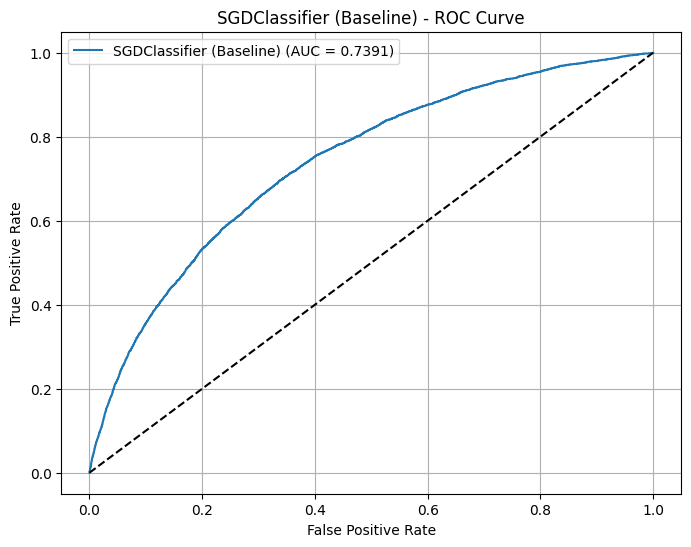

[I 2025-04-06 12:09:34,799] Using an existing study with name 'sgd_optimization' instead of creating a new one.



--- Optuna Optimization for SGDClassifier ---
Starting Optuna optimization for SGD with 50 trials...


[I 2025-04-06 12:11:56,981] Trial 2 finished with value: 0.6394475460750847 and parameters: {'alpha': 1.3194635113544997e-05, 'max_iter': 1393, 'loss': 'modified_huber', 'penalty': 'l2', 'class_weight': 'balanced', 'learning_rate': 'optimal'}. Best is trial 0 with value: 0.7499215372539568.
[I 2025-04-06 12:13:51,201] Trial 3 finished with value: 0.7376082487870776 and parameters: {'alpha': 0.00012595846612935822, 'max_iter': 2219, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'optimal'}. Best is trial 0 with value: 0.7499215372539568.
[I 2025-04-06 12:15:18,778] Trial 4 finished with value: 0.7489459079638969 and parameters: {'alpha': 0.023606991544913497, 'max_iter': 2852, 'loss': 'modified_huber', 'penalty': 'l2', 'class_weight': None, 'learning_rate': 'invscaling', 'eta0': 0.00231613732259894}. Best is trial 0 with value: 0.7499215372539568.
[I 2025-04-06 12:16:47,348] Trial 5 finished with value: 0.7245970950960378 and parameters: {'alph

Optuna optimization completed in 88.89 minutes

Best Params (SGDClassifier): {'alpha': 0.0012743143128009645, 'max_iter': 1886, 'loss': 'log_loss', 'penalty': 'elasticnet', 'class_weight': 'balanced', 'learning_rate': 'adaptive', 'eta0': 0.004289064566392123}
Best CV ROC AUC score: 0.7513

Fitting best SGD pipeline on full training data...

Evaluating tuned SGD model...
Optimal threshold based on Youden's J-Statistic (OOF): 0.4757

--- Evaluation Metrics for SGDClassifier (Optuna Tuned) ---
AUC ROC:        0.7562
Gini Coefficient: 0.5124
KS Statistic:   0.3814
Accuracy:       0.6810
Precision:      0.1603
Recall (TPR):   0.6965
F1-Score:       0.2606
Brier Score:    0.1944
Log Loss:       0.5731

Confusion Matrix:
[[38423 18114]
 [ 1507  3458]]


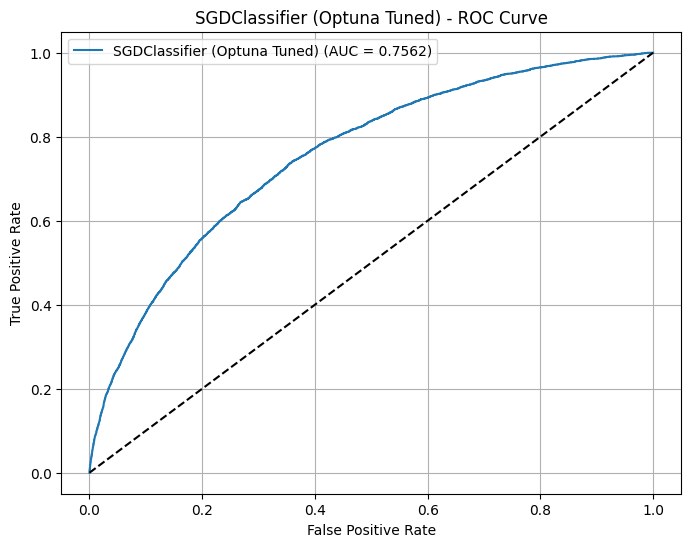


--- Top 50 Feature Importances ---
Sum of importances: 12.2277


,feature,importance
80,EXT_SOURCE_MEAN,0.28616
83,WEIGHTED_EXT_SOURCE,0.28260
47,FLAG_DOCUMENT_3,0.26459
143,AGE_EMPLOYED_DIFF_MEAN_AGG_OCCUPATION_TYPE_ORG...,0.26125
151,ANNUITY_INCOME_RATIO_MAX_AGG_CODE_GENDER_FLAG_...,0.25511
4,AMT_GOODS_PRICE,0.21562
3,AMT_ANNUITY,0.21319
415,B_B_CURRENT_CREDIT_DEBT_DIFF_SUM_OVERALL,0.21236
135,AGE_EMPLOYED_DIFF_MIN_AGG_NAME_EDUCATION_TYPE_...,0.18739
136,AMT_INCOME_TOTAL_MEAN_AGG_NAME_EDUCATION_TYPE_...,0.18160


In [30]:
# --- Model 2: SGDClassifier with Optuna Optimization ---
print("\n" + "="*60)
print("Model 2: SGDClassifier with Optuna Optimization")
print("="*60)

# Step 2.1: Baseline Pipeline (No change needed here)
print("\n--- Baseline SGDClassifier Training ---")
sgd_base_pipeline = ImblearnPipeline([
    ('smote', SMOTE_VARIANT), # Keep SMOTE here
    ('scaler', StandardScaler()),
    ('model', SGDClassifier(loss='log_loss', penalty='l2', random_state=SEED,
                            class_weight='balanced', n_jobs=-1, tol=1e-3))
])

sgd_base_pipeline.fit(X_train, y_train)
y_pred_proba_test_base = sgd_base_pipeline.predict_proba(X_test)[:, 1]
y_pred_bin_test_base = (y_pred_proba_test_base >= 0.5).astype(int)
baseline_results.append(evaluate_model(y_test, y_pred_proba_test_base, y_pred_bin_test_base, "SGDClassifier (Baseline)"))
plot_roc_curve(y_test, y_pred_proba_test_base, "SGDClassifier (Baseline)")

# Step 2.2: Optuna Hyperparameter Optimization
print("\n--- Optuna Optimization for SGDClassifier ---")

# Define the objective function for Optuna
def objective_sgd(trial):
    # Define hyperparameters to tune
    alpha = trial.suggest_float('alpha', 1e-5, 1.0, log=True)
    max_iter = trial.suggest_int('max_iter', 500, 3000)
    loss = trial.suggest_categorical('loss', ['log_loss', 'modified_huber'])
    penalty = trial.suggest_categorical('penalty', ['l2', 'elasticnet'])
    l1_ratio = 0.15 # Default if penalty is elasticnet, fixed here for simplicity, could also tune
    class_weight_opt = trial.suggest_categorical('class_weight', ['balanced', None])
    learning_rate = trial.suggest_categorical('learning_rate', ['optimal', 'constant', 'invscaling', 'adaptive'])
    eta0 = 0.01 
    if learning_rate != 'optimal':
        eta0 = trial.suggest_float('eta0', 1e-4, 0.5, log=True)


    # Create the pipeline with suggested parameters
    pipeline = ImblearnPipeline([
        ('smote', SMOTE_VARIANT),
        ('scaler', StandardScaler()),
        ('model', SGDClassifier(
            loss=loss,
            penalty=penalty,
            alpha=alpha,
            l1_ratio=l1_ratio if penalty == 'elasticnet' else 0.15, # Apply l1_ratio only if relevant
            max_iter=max_iter,
            class_weight=class_weight_opt,
            learning_rate=learning_rate,
            eta0=eta0,
            random_state=SEED,
            n_jobs=-1,
            tol=1e-3 # Use tolerance for convergence
        ))
    ])

    # Evaluate using cross-validation
    try:
        # Using roc_auc as the optimization target
        scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
        auc_score = np.mean(scores)
        # Handle potential errors during CV
        if np.isnan(auc_score):
            return 0.0 # Return low score if CV fails
        return auc_score
    except Exception as e:
        print(f"Trial failed with error: {e}")
        return 0.0 # Return low score for failed trials

# Create an Optuna study
study_sgd = optuna.create_study(direction='maximize',
                                study_name='sgd_optimization',
                                storage=f'sqlite:///{MODEL_OUTPUT_PATH}optuna_studies.db', # Save study progress
                                load_if_exists=True) # Resume if exists

# Run optimization
print(f"Starting Optuna optimization for SGD with {OPTUNA_N_TRIALS} trials...")
start_time = time.time()
study_sgd.optimize(objective_sgd, n_trials=OPTUNA_N_TRIALS, n_jobs=1) # n_jobs=1 for Optuna itself, CV runs in parallel if n_jobs=-1 in cross_val_score
end_time = time.time()
print(f"Optuna optimization completed in {(end_time - start_time)/60:.2f} minutes")

# Get best parameters and build the final pipeline
best_params_sgd_raw = study_sgd.best_params
# Need to prefix with 'model__' for pipeline
best_params_sgd = {f'model__{k}': v for k, v in best_params_sgd_raw.items()}
print(f"\nBest Params (SGDClassifier): {best_params_sgd_raw}")
print(f"Best CV ROC AUC score: {study_sgd.best_value:.4f}")

best_sgd_pipeline = ImblearnPipeline([
    ('smote', SMOTE_VARIANT),
    ('scaler', StandardScaler()),
    ('model', SGDClassifier(random_state=SEED, n_jobs=-1, tol=1e-3))
])
best_sgd_pipeline.set_params(**best_params_sgd)

# Fit the best pipeline on the full training data
print("\nFitting best SGD pipeline on full training data...")
best_sgd_pipeline.fit(X_train, y_train)

# Step 2.3: Optimal Threshold and Evaluation
print("\nEvaluating tuned SGD model...")
y_prob_oof_sgd = cross_val_predict(best_sgd_pipeline, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
optimal_threshold_sgd = find_optimal_threshold_j_statistic(y_train, y_prob_oof_sgd)

y_pred_proba_test_tuned = best_sgd_pipeline.predict_proba(X_test)[:, 1]
y_pred_bin_test_tuned = (y_pred_proba_test_tuned >= optimal_threshold_sgd).astype(int)
tuned_results.append(evaluate_model(y_test, y_pred_proba_test_tuned, y_pred_bin_test_tuned, "SGDClassifier (Optuna Tuned)"))
plot_roc_curve(y_test, y_pred_proba_test_tuned, "SGDClassifier (Optuna Tuned)")

# Feature importance via coefficients
final_sgd_model = best_sgd_pipeline.named_steps['model']
if hasattr(final_sgd_model, 'coef_'):
     get_feature_importance(final_sgd_model, feature_names)

model_objects['SGD'] = best_sgd_pipeline # Store the best pipeline

# 5. Model 3: XGBoost


Model 3: XGBoost with Optuna Optimization & GPU

--- Baseline XGBoost Training ---

--- Evaluation Metrics for XGBoost (Baseline) ---
AUC ROC:        0.7637
Gini Coefficient: 0.5275
KS Statistic:   0.3938
Accuracy:       0.9194
Precision:      0.5077
Recall (TPR):   0.0532
F1-Score:       0.0963
Brier Score:    0.0678
Log Loss:       0.2454

Confusion Matrix:
[[56281   256]
 [ 4701   264]]


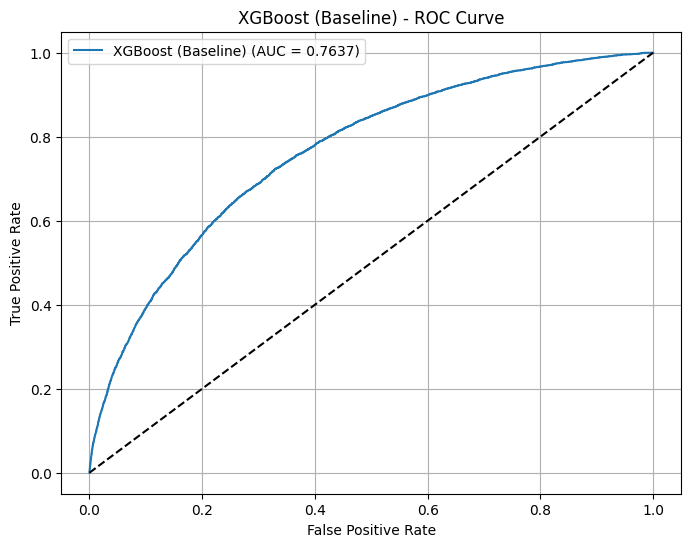


--- Top 50 Feature Importances ---
Sum of importances: 1.0000


,feature,importance
32,YEARS_BEGINEXPLUATATION_MODE,0.06732
22,REG_CITY_NOT_WORK_CITY,0.06256
37,YEARS_BEGINEXPLUATATION_MEDI,0.04230
12,FLAG_PHONE,0.04127
47,FLAG_DOCUMENT_3,0.03985
10,FLAG_EMP_PHONE,0.03885
80,EXT_SOURCE_MEAN,0.03159
357,B_BB_STATUS_ENCODED_LAST_YEAR_REST_MAX_OVERALL,0.03088
15,REGION_RATING_CLIENT,0.02729
204,B_DAYS_CREDIT_UPDATE_MAX_OVERALL,0.02194


[I 2025-04-06 13:41:53,555] A new study created in RDB with name: xgb_optimization



--- Optuna Optimization for XGBoost ---
Starting Optuna optimization for XGBoost with 50 trials...


[I 2025-04-06 13:47:34,510] Trial 0 finished with value: 0.7275571441889419 and parameters: {'n_estimators': 861, 'max_depth': 6, 'learning_rate': 0.20794137384406222, 'subsample': 0.6362373253230805, 'colsample_bytree': 0.8040785720282233, 'gamma': 0.23475353202639293, 'reg_alpha': 0.0022563524050639174, 'reg_lambda': 3.920513426183385e-06}. Best is trial 0 with value: 0.7275571441889419.
[I 2025-04-06 13:53:03,004] Trial 1 finished with value: 0.7632961273476453 and parameters: {'n_estimators': 559, 'max_depth': 7, 'learning_rate': 0.010613471195991252, 'subsample': 0.6831748187126616, 'colsample_bytree': 0.9643978248866373, 'gamma': 0.31289013207855154, 'reg_alpha': 0.8543315947516902, 'reg_lambda': 0.00830824839055759}. Best is trial 1 with value: 0.7632961273476453.
[I 2025-04-06 13:55:31,744] Trial 2 finished with value: 0.7621480328694101 and parameters: {'n_estimators': 261, 'max_depth': 3, 'learning_rate': 0.07945957788161542, 'subsample': 0.8435183148794857, 'colsample_bytree

Optuna optimization completed in 259.42 minutes

Best Params (XGBoost): {'n_estimators': 885, 'max_depth': 5, 'learning_rate': 0.03403403054943392, 'subsample': 0.9211626143507777, 'colsample_bytree': 0.8820452389615568, 'gamma': 0.3085863326581829, 'reg_alpha': 0.9898923552248042, 'reg_lambda': 1.1509427732651694e-07}
Best CV ROC AUC score: 0.7739

Fitting best XGBoost pipeline on full training data...

Evaluating tuned XGBoost model...
Optimal threshold based on Youden's J-Statistic (OOF): 0.0823

--- Evaluation Metrics for XGBoost (Optuna Tuned) ---
AUC ROC:        0.7766
Gini Coefficient: 0.5533
KS Statistic:   0.4141
Accuracy:       0.7041
Precision:      0.1735
Recall (TPR):   0.7082
F1-Score:       0.2787
Brier Score:    0.0665
Log Loss:       0.2402

Confusion Matrix:
[[39788 16749]
 [ 1449  3516]]


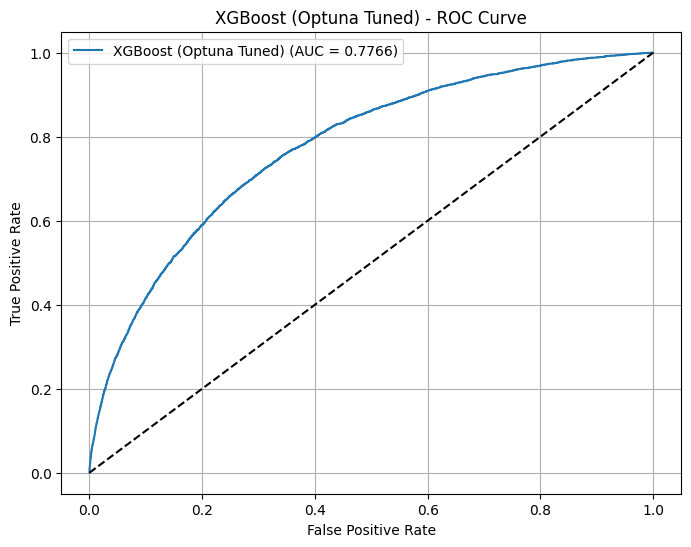


--- Top 50 Feature Importances ---
Sum of importances: 1.0000


,feature,importance
22,REG_CITY_NOT_WORK_CITY,0.06647
32,YEARS_BEGINEXPLUATATION_MODE,0.04306
47,FLAG_DOCUMENT_3,0.04175
12,FLAG_PHONE,0.04060
15,REGION_RATING_CLIENT,0.03540
357,B_BB_STATUS_ENCODED_LAST_YEAR_REST_MAX_OVERALL,0.02555
80,EXT_SOURCE_MEAN,0.02552
37,YEARS_BEGINEXPLUATATION_MEDI,0.02414
72,CNT_NON_CHILDREN,0.01987
79,FLAG_REGIONS_SUM,0.01787


In [31]:
# --- Model 3: XGBoost with Optuna Optimization & GPU ---
print("\n" + "="*60)
print("Model 3: XGBoost with Optuna Optimization & GPU")
print("="*60)

# Step 3.1: Baseline Pipeline (Add GPU option)
print("\n--- Baseline XGBoost Training ---")
xgb_base_pipeline = ImblearnPipeline([
    ('smote', SMOTE_VARIANT),
    ('scaler', StandardScaler()),
    ('model', xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
                                use_label_encoder=False, random_state=SEED, n_jobs=-1,
                                tree_method='gpu_hist' if device_name == 'cuda' else 'hist' # Enable GPU if available
                               ))
])
xgb_base_pipeline.fit(X_train, y_train)
y_pred_proba_test_base = xgb_base_pipeline.predict_proba(X_test)[:, 1]
y_pred_bin_test_base = (y_pred_proba_test_base >= 0.5).astype(int)
baseline_results.append(evaluate_model(y_test, y_pred_proba_test_base, y_pred_bin_test_base, "XGBoost (Baseline)"))
plot_roc_curve(y_test, y_pred_proba_test_base, "XGBoost (Baseline)")
get_feature_importance(xgb_base_pipeline.named_steps['model'], feature_names)

# Step 3.2: Optuna Hyperparameter Optimization
print("\n--- Optuna Optimization for XGBoost ---")

def objective_xgb(trial):
    # Define hyperparameters
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'use_label_encoder': False,
        'random_state': SEED,
        'n_jobs': -1,
        'tree_method': 'gpu_hist' if device_name == 'cuda' else 'hist' # Enable GPU
    }

    pipeline = ImblearnPipeline([
        ('smote', SMOTE_VARIANT),
        ('scaler', StandardScaler()),
        ('model', xgb.XGBClassifier(**param))
    ])

    # Evaluate using cross-validation
    try:
        scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
        auc_score = np.mean(scores)
        if np.isnan(auc_score): return 0.0
        return auc_score
    except Exception as e:
        print(f"Trial failed with error: {e}")
        return 0.0

# Create and run study
study_xgb = optuna.create_study(direction='maximize',
                                study_name='xgb_optimization',
                                storage=f'sqlite:///{MODEL_OUTPUT_PATH}optuna_studies.db',
                                load_if_exists=True)

print(f"Starting Optuna optimization for XGBoost with {OPTUNA_N_TRIALS} trials...")
start_time = time.time()
study_xgb.optimize(objective_xgb, n_trials=OPTUNA_N_TRIALS, n_jobs=1)
end_time = time.time()
print(f"Optuna optimization completed in {(end_time - start_time)/60:.2f} minutes")

# Get best parameters and build final pipeline
best_params_xgb_raw = study_xgb.best_params
best_params_xgb = {f'model__{k}': v for k, v in best_params_xgb_raw.items()}
print(f"\nBest Params (XGBoost): {best_params_xgb_raw}")
print(f"Best CV ROC AUC score: {study_xgb.best_value:.4f}")

best_xgb_pipeline = ImblearnPipeline([
    ('smote', SMOTE_VARIANT),
    ('scaler', StandardScaler()),
    ('model', xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
                                use_label_encoder=False, random_state=SEED, n_jobs=-1,
                                tree_method='gpu_hist' if device_name == 'cuda' else 'hist'))
])
# Update only the tuned parameters
best_xgb_pipeline.set_params(**best_params_xgb)


print("\nFitting best XGBoost pipeline on full training data...")
best_xgb_pipeline.fit(X_train, y_train)

# Step 3.3: Optimal Threshold and Evaluation
print("\nEvaluating tuned XGBoost model...")
y_prob_oof_xgb = cross_val_predict(best_xgb_pipeline, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
optimal_threshold_xgb = find_optimal_threshold_j_statistic(y_train, y_prob_oof_xgb)

y_pred_proba_test_tuned = best_xgb_pipeline.predict_proba(X_test)[:, 1]
y_pred_bin_test_tuned = (y_pred_proba_test_tuned >= optimal_threshold_xgb).astype(int)
tuned_results.append(evaluate_model(y_test, y_pred_proba_test_tuned, y_pred_bin_test_tuned, "XGBoost (Optuna Tuned)"))
plot_roc_curve(y_test, y_pred_proba_test_tuned, "XGBoost (Optuna Tuned)")
get_feature_importance(best_xgb_pipeline.named_steps['model'], feature_names)
model_objects['XGB'] = best_xgb_pipeline # Store the best pipeline  

# 6. Model 4: LightGBM


Model 4: LightGBM with Optuna Optimization & GPU

--- Baseline LightGBM Training ---
[LightGBM] [Info] Number of positive: 56536, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.360203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126897
[LightGBM] [Info] Number of data points in the train set: 282681, number of used features: 528
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199999 -> initscore=-1.386299
[LightGBM] [Info] Start training from score -1.386299

--- Evaluation Metrics for LightGBM (Baseline) ---
AUC ROC:        0.7728
Gini Coefficient: 0.5457
KS Statistic:   0.4073
Accuracy:       0.9198
Precision:      0.5845
Recall (TPR):   0.0244
F1-Score:       0.0468
Brier Score:    0.0669
Log Loss:       0.2420

Confusion Matrix:
[[56451    86]
 [ 4844   121]]


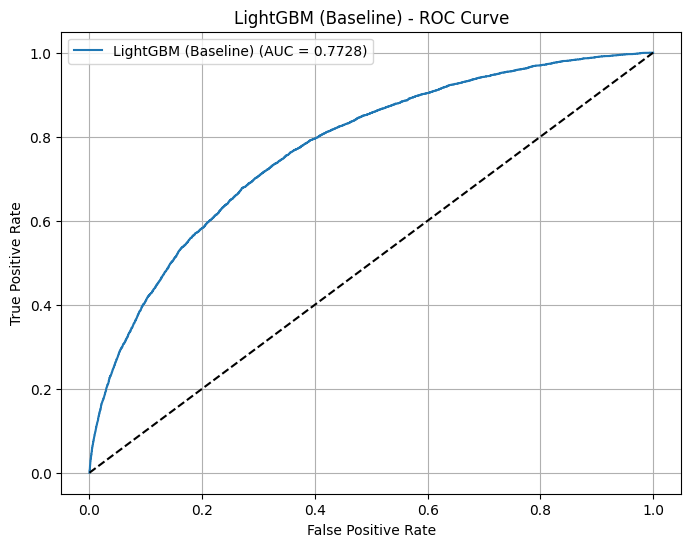


--- Top 50 Feature Importances ---
Sum of importances: 3000.0000


,feature,importance
57,CREDIT_ANNUITY_RATIO,115
80,EXT_SOURCE_MEAN,93
83,WEIGHTED_EXT_SOURCE,80
429,B_CREDIT_CURRENCY_CURRENCY 1_MEAN,70
55,AMT_REQ_CREDIT_BUREAU_YEAR,64
11,FLAG_WORK_PHONE,60
5,DAYS_BIRTH,55
16,REGION_RATING_CLIENT_W_CITY,50
47,FLAG_DOCUMENT_3,44
82,EXT_SOURCE_MIN,43


[I 2025-04-06 18:08:57,601] A new study created in RDB with name: lgbm_optimization



--- Optuna Optimization for LightGBM ---
Starting Optuna optimization for LightGBM with 50 trials...


[I 2025-04-06 18:10:48,400] Trial 0 finished with value: 0.7376670315547843 and parameters: {'n_estimators': 110, 'learning_rate': 0.026700978914781487, 'num_leaves': 34, 'max_depth': 4, 'subsample': 0.6453077951904033, 'colsample_bytree': 0.798765711390395, 'reg_alpha': 9.728991736790276e-05, 'reg_lambda': 0.00022423293872905954}. Best is trial 0 with value: 0.7376670315547843.
[I 2025-04-06 18:20:29,975] Trial 1 finished with value: 0.7717544033554923 and parameters: {'n_estimators': 950, 'learning_rate': 0.014496109917135515, 'num_leaves': 30, 'max_depth': 11, 'subsample': 0.8785415616137884, 'colsample_bytree': 0.7322154726312486, 'reg_alpha': 0.0001999003959824839, 'reg_lambda': 0.0021369689072941738}. Best is trial 1 with value: 0.7717544033554923.
[I 2025-04-06 18:26:01,376] Trial 2 finished with value: 0.7662270942697625 and parameters: {'n_estimators': 626, 'learning_rate': 0.0725582014870468, 'num_leaves': 81, 'max_depth': 7, 'subsample': 0.6807000895082382, 'colsample_bytree

KeyboardInterrupt: 

In [32]:
# --- Model 4: LightGBM with Optuna Optimization & GPU ---
print("\n" + "="*60)
print("Model 4: LightGBM with Optuna Optimization & GPU")
print("="*60)

# Step 4.1: Baseline Pipeline (Add GPU option)
print("\n--- Baseline LightGBM Training ---")
lgb_base_pipeline = ImblearnPipeline([
    ('smote', SMOTE_VARIANT),
    ('scaler', StandardScaler()),
    ('model', lgb.LGBMClassifier(objective='binary', metric='auc', random_state=SEED, n_jobs=-1,
                                 device='gpu' if device_name == 'cuda' else 'cpu' # Enable GPU if available
                                ))
])
lgb_base_pipeline.fit(X_train, y_train)
y_pred_proba_test_base = lgb_base_pipeline.predict_proba(X_test)[:, 1]
y_pred_bin_test_base = (y_pred_proba_test_base >= 0.5).astype(int)
baseline_results.append(evaluate_model(y_test, y_pred_proba_test_base, y_pred_bin_test_base, "LightGBM (Baseline)"))
plot_roc_curve(y_test, y_pred_proba_test_base, "LightGBM (Baseline)")
get_feature_importance(lgb_base_pipeline.named_steps['model'], feature_names)

# Step 4.2: Optuna Hyperparameter Optimization
print("\n--- Optuna Optimization for LightGBM ---")

def objective_lgbm(trial):
    # Define hyperparameters
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'random_state': SEED,
        'n_jobs': -1,
        'device': 'gpu' if device_name == 'cuda' else 'cpu', # Enable GPU
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        # 'min_child_samples': trial.suggest_int('min_child_samples', 5, 100), # Optional: depends on dataset size
    }

    pipeline = ImblearnPipeline([
        ('smote', SMOTE_VARIANT),
        ('scaler', StandardScaler()),
        ('model', lgb.LGBMClassifier(**param))
    ])

    # Evaluate using cross-validation
    try:
        scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
        auc_score = np.mean(scores)
        if np.isnan(auc_score): return 0.0
        return auc_score
    except Exception as e:
        # LightGBM can sometimes throw errors with certain parameter combos
        print(f"Trial failed with error: {e}")
        return 0.0

# Create and run study
study_lgbm = optuna.create_study(direction='maximize',
                                study_name='lgbm_optimization',
                                storage=f'sqlite:///{MODEL_OUTPUT_PATH}optuna_studies.db',
                                load_if_exists=True)

print(f"Starting Optuna optimization for LightGBM with {OPTUNA_N_TRIALS} trials...")
start_time = time.time()
study_lgbm.optimize(objective_lgbm, n_trials=OPTUNA_N_TRIALS, n_jobs=1)
end_time = time.time()
print(f"Optuna optimization completed in {(end_time - start_time)/60:.2f} minutes")

# Get best parameters and build final pipeline
best_params_lgbm_raw = study_lgbm.best_params
best_params_lgbm = {f'model__{k}': v for k, v in best_params_lgbm_raw.items()}
print(f"\nBest Params (LightGBM): {best_params_lgbm_raw}")
print(f"Best CV ROC AUC score: {study_lgbm.best_value:.4f}")

best_lgb_pipeline = ImblearnPipeline([
    ('smote', SMOTE_VARIANT),
    ('scaler', StandardScaler()),
    ('model', lgb.LGBMClassifier(objective='binary', metric='auc', random_state=SEED, n_jobs=-1,
                                 device='gpu' if device_name == 'cuda' else 'cpu'))
])
# Update only the tuned parameters
best_lgb_pipeline.set_params(**best_params_lgbm)

print("\nFitting best LightGBM pipeline on full training data...")
best_lgb_pipeline.fit(X_train, y_train)

# Step 4.3: Optimal Threshold and Evaluation
print("\nEvaluating tuned LightGBM model...")
y_prob_oof_lgb = cross_val_predict(best_lgb_pipeline, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
optimal_threshold_lgb = find_optimal_threshold_j_statistic(y_train, y_prob_oof_lgb)

y_pred_proba_test_tuned = best_lgb_pipeline.predict_proba(X_test)[:, 1]
y_pred_bin_test_tuned = (y_pred_proba_test_tuned >= optimal_threshold_lgb).astype(int)
tuned_results.append(evaluate_model(y_test, y_pred_proba_test_tuned, y_pred_bin_test_tuned, "LightGBM (Optuna Tuned)"))
plot_roc_curve(y_test, y_pred_proba_test_tuned, "LightGBM (Optuna Tuned)")
get_feature_importance(best_lgb_pipeline.named_steps['model'], feature_names)
model_objects['LGBM'] = best_lgb_pipeline # Store the best pipeline

# 7. Model 5: Stacking Classifier

In [ ]:
# --- Model 5: Stacking Classifier ---
print("\n" + "="*60)
print("Model 6: Stacking Classifier")
print("="*60)

# Check if base models were successfully trained and stored
base_models_available = [name for name in ['LR_WOE', 'SGD', 'XGB', 'LGBM'] if name in model_objects]

if len(base_models_available) < 2:
    print("Need at least 2 successfully tuned base models to perform stacking. Skipping.")
    baseline_results.append({'Model': 'Stacking (Baseline)', 'AUC': np.nan}) # Add placeholder results
    tuned_results.append({'Model': 'Stacking (Tuned)', 'AUC': np.nan})
else:
    print(f"Using base models: {base_models_available}")

    # Define base estimators using the best pipelines/models found
    # Note: LR_WOE needs special handling as it uses pre-transformed data
    estimators = []
    # Need a way to handle the WOE input for the LR_WOE base model within StackingClassifier
    # This is complex. A common workaround is to retrain the non-WOE models without SMOTE/Scaling
    # within the stacking pipeline if the meta-learner benefits from raw probabilities.
    # OR, create custom transformers for WOE application within the stacking framework.
    # For simplicity here, let's use the pipelines *as is*, acknowledging potential inefficiencies.
    # We will exclude LR_WOE for now due to the input data difference.
    estimators = [(name, model_objects[name]) for name in base_models_available if name != 'LR_WOE']

    if not estimators:
         print("No suitable non-WOE base models found for stacking. Skipping.")
         baseline_results.append({'Model': 'Stacking (Baseline)', 'AUC': np.nan})
         tuned_results.append({'Model': 'Stacking (Tuned)', 'AUC': np.nan})
    else:
        # Define Meta Learner
        meta_learner = LogisticRegression(random_state=SEED, class_weight='balanced', n_jobs=-1)

        # Create Stacking Classifier
        # Use 'predict_proba' for stack_method as meta-learner often benefits from probabilities
        # `passthrough=False` means only the predictions of base models are passed to meta-learner
        stacking_clf = StackingClassifier(
            estimators=estimators,
            final_estimator=meta_learner,
            cv=cv, # Use the same CV strategy for generating base model predictions
            stack_method='predict_proba',
            n_jobs=-1,
            passthrough=False # Usually False is better unless meta-learner needs original features too
        )

        # Train the Stacking Classifier
        print("Training Stacking Classifier...")
        start_stack_time = time.time()
        stacking_clf.fit(X_train, y_train)
        end_stack_time = time.time()
        print(f"Stacking Training Time: {(end_stack_time - start_stack_time)/60:.2f} minutes")


        # Optimal Threshold and Evaluation
        # Get OOF predictions (using internal CV of StackingClassifier isn't straightforward for threshold tuning)
        # Re-run cross_val_predict with the *fitted* stacking classifier is one way,
        # but might be computationally expensive as it retrains.
        # Alternative: Use the internal OOF predictions if accessible (not standard in sklearn's StackingClassifier)
        # Simplest approach for now: Use the fitted model and evaluate directly, find threshold on test preds (less ideal)
        # Or: find threshold on OOF predictions of the *meta-learner* if we could extract them.
        # Let's proceed with direct evaluation and acknowledge thresholding limitation here.

        print("Evaluating Stacking Classifier...")
        y_pred_proba_test_stack = stacking_clf.predict_proba(X_test)[:, 1]

        # Find threshold on test set probabilities (Sub-optimal, but simple for this structure)
        # Ideally, you'd get OOF predictions from the *stacking* process on the training set.
        # optimal_threshold_stack = find_optimal_threshold_j_statistic(y_test, y_pred_proba_test_stack) # Find on test for demo

        # For consistency, let's try getting OOF on train (might be slow)
        print("Getting OOF predictions for Stacking threshold tuning (may take time)...")
        y_prob_oof_stack = cross_val_predict(stacking_clf, X_train, y_train, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
        optimal_threshold_stack = find_optimal_threshold_j_statistic(y_train, y_prob_oof_stack)

        y_pred_bin_test_stack = (y_pred_proba_test_stack >= optimal_threshold_stack).astype(int)

        # Store as both baseline and tuned result for Stacking
        stacking_eval_results = evaluate_model(y_test, y_pred_proba_test_stack, y_pred_bin_test_stack, "Stacking Classifier")
        baseline_results.append(stacking_eval_results)
        tuned_results.append(stacking_eval_results) # No separate tuning step shown here

        plot_roc_curve(y_test, y_pred_proba_test_stack, "Stacking Classifier")
        # Feature importance for stacking is typically done via SHAP on the meta-learner or permutation importance.
        # Or examine coefficients of the meta-learner:
        if hasattr(stacking_clf.final_estimator_, 'coef_'):
            print("\nMeta-Learner Coefficients (Importance of Base Models):")
            meta_coefs = pd.DataFrame({
                'Base Model': [name for name, _ in estimators],
                'Coefficient': np.abs(stacking_clf.final_estimator_.coef_[0]) # Abs value for importance magnitude
            }).sort_values('Coefficient', ascending=False)
            display(meta_coefs)
        model_objects['Stacking'] = stacking_clf # Store the model

# 8. Model Evaluation

In [ ]:
# --- Final Results Comparison ---
print("\n" + "="*60)
print("Overall Model Comparison")
print("="*60)

baseline_results_df = pd.DataFrame(baseline_results).set_index('Model')
tuned_results_df = pd.DataFrame(tuned_results).set_index('Model') # Now contains Optuna results

print("\n--- Baseline Model Performance (Test Set, Threshold=0.5 or Balanced Weight) ---")
display(baseline_results_df.sort_values('AUC', ascending=False))

print("\n--- Tuned Model Performance (Test Set, Optimal Threshold via Youden's J on OOF) ---")
display(tuned_results_df.sort_values('AUC', ascending=False))

# --- Save Results ---
baseline_results_df.to_csv(os.path.join(MODEL_OUTPUT_PATH, "baseline_model_results.csv"))
tuned_results_df.to_csv(os.path.join(MODEL_OUTPUT_PATH, "tuned_model_results_optuna.csv")) # Updated filename
print(f"\nResults saved to {MODEL_OUTPUT_PATH}")

# Optionally save the best models
# model_save_path = os.path.join(MODEL_OUTPUT_PATH, 'best_models_optuna.pkl')
# try:
#     with open(model_save_path, 'wb') as f:
#         pickle.dump(model_objects, f)
#     print(f"Best model objects saved to {model_save_path}")
# except Exception as e:
#     print(f"Could not save models: {e}")


# Optionally save the Optuna studies (they are also saved to the sqlite DB)
# study_sgd.trials_dataframe().to_csv(os.path.join(MODEL_OUTPUT_PATH, 'optuna_sgd_trials.csv'))
# study_xgb.trials_dataframe().to_csv(os.path.join(MODEL_OUTPUT_PATH, 'optuna_xgb_trials.csv'))
# study_lgbm.trials_dataframe().to_csv(os.path.join(MODEL_OUTPUT_PATH, 'optuna_lgbm_trials.csv'))

print("\nModeling complete.")